In [35]:
managers = {
    "humanlike": {
        "type": "human",
        "path": "artifacts/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt",
        "autoregressive": True,
    },
    "optimal": {
        "type": "rl",
        "path": "artifacts/manager/05_n_rounds/model/n_rounds_24.pt",
    },
}
n_episode_steps = 24
n_episodes = 4
output_dir = "../../notebooks/test_manager/simulate_mixed/02_all_artifacts"
basedir = "../.."


In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
import random
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment import ArtificialHumanEnv

from aimanager.manager.api_manager import MultiManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

plot_folder = output_dir

make_dir(plot_folder)

managers = {k:{**v, 'model_path': os.path.join(basedir, v['path'])} for k,v in managers.items()}
managers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'humanlike': {'type': 'human',
  'path': 'artifacts/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt',
  'autoregressive': True,
  'model_path': '../../artifacts/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt'},
 'optimal': {'type': 'rl',
  'path': 'artifacts/manager/05_n_rounds/model/n_rounds_24.pt',
  'model_path': '../../artifacts/manager/05_n_rounds/model/n_rounds_24.pt'}}

In [37]:
def mem_to_df(recorder, name):
    columns = ['episode','participant_code','round_number']

    punishments = using_multiindex(recorder.memory['punishment'].squeeze(1).numpy(), columns=columns, value_name='punishment')
    # common_good = using_multiindex(recorder.memory['common_good'].squeeze(1).numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contribution'].squeeze(1).numpy(), columns=columns, value_name='contribution')
    group = using_multiindex(recorder.memory['group'].squeeze(1).numpy(), columns=columns, value_name='group')

    df_sim = punishments.merge(contributions).merge(group)

    df_sim['participant_code'] = df_sim['participant_code'].astype(str) + '_' + df_sim['episode'].astype(str)

    df_sim['run'] = name
    return df_sim

def make_round(contributions, round, groups, episode_group_idx):
    return {
        'contribution': contributions,
        'contribution_valid': [c is not None for c in contributions],
        'punishment_valid': [False] * len(contributions),
        'punishment': [None] * len(contributions),
        'group': groups,
        'round': round,
        'episode_group_idx': episode_group_idx
    }

def add_punishments(round, punishments):
    return {
        **round,
        'punishment': punishments,
        'punishment_valid': [p is not None for p in punishments],
    }


In [69]:
device = th.device('cpu')
rec_device = th.device('cpu')
n_agents = 4

mm = MultiManager(
    managers,
    n_steps=n_episode_steps,
)

# fix bug
for k, man  in mm.managers.items():
    if 'autoregressive' in managers[k]:
        man.model.autoregressive = managers[k]['autoregressive']

dfs = []
data = {'round': [], 'agent': [], 'contribution': [], 'punishment': [], 'manager': [], 'episode': []}
for m in managers:
    groups = [m]*n_agents
    n_agents = len(groups)
    for e in range(n_episodes):

        episode_group_idx = random.randint(0,1000000)
        rounds = []
        for round_number in range(n_episode_steps):
            contribution = random.randint(0, 20)
            # contributions = [random.randint(0, 20) for _ in range(n_agents)]
            contributions = [contribution]*n_agents

            round = make_round(contributions, round_number, groups, episode_group_idx)
            punishments = mm.get_punishments(rounds+[round])[0]
            round = add_punishments(round, punishments)
            rounds.append(round)
            data['episode'].extend([e]*n_agents)
            data['manager'].extend([m]*n_agents)
            data['round'].extend([round_number]*n_agents)
            data['agent'].extend(range(n_agents))
            data['contribution'].extend(contributions)
            data['punishment'].extend(punishments)
            break
        break
    break

contribution tensor([[[ 7],
         [ 7],
         [ 7],
         [ 7]],

        [[13],
         [13],
         [13],
         [13]]])
autoreg_mask tensor([[[True],
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         [True]]])
y_mask tensor([[[0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0]]])
y_pred_proba tensor([[[6.0245e-01, 4.8752e-02, 1.0115e-01, 5.6561e-02, 1.1123e-02,
          5.5245e-02, 9.5943e-03, 1.4263e-02, 1.8400e-02, 1.4097e-02,
          1.3271e-02, 1.1464e-02, 5.7400e-03, 4.0842e-03, 4.8156e-03,
          8.9303e-03, 5.9639e-03, 9.0049e-03, 1.0137e-03, 2.3887e-04,
          3.7915e-04, 1.4416e-04, 6.1282e-05, 7.5532e-05, 7.1685e-05,
          6.3776e-04, 2.3507e-04, 7.3454e-04, 5.6012e-04, 2.1208e-04,
          7.2037e-04]],

        [[9.9536e-01, 2.6343e-03, 1.3037e-03, 3.2056e-04, 4.8986e-05,
          1.6673e-04, 2.3905e-05, 2.1260e-05, 1.9529e-05, 1

In [68]:
contribution

16

In [52]:
punishments

[5, 7, 2, 8]

In [40]:
df = pd.DataFrame(data)

In [44]:
df[df.episode == 3].head()

,round,agent,contribution,punishment,manager,episode
288,0,0,1,10,humanlike,3
289,0,1,1,8,humanlike,3
290,0,2,1,10,humanlike,3
291,0,3,1,11,humanlike,3
292,1,0,13,30,humanlike,3


In [ ]:
data_file = 'experiments/pilot_random1_player_round_slim.csv'
data_file = os.path.join(basedir, data_file)

df_pilot = pd.read_csv(data_file)

experiment_name_map = {
    'trail_rounds_2': 'pilot human manager',
    'random_1': 'pilot rule based manager'
}

df_pilot['run'] = df_pilot['experiment_name'].map(experiment_name_map)
df_pilot['common_good'] = df_pilot['common_good'] / 4
df_pilot['episode'] = df_pilot['episode_id']
df_pilot = df_pilot[['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'run', 'episode']]


df = pd.concat([*dfs, df_pilot]).reset_index(drop=True)

df['episode'] = df['run'] + '__' + df['episode'].astype(str)

dfm = df.melt(
    id_vars=['episode', 'round_number', 'participant_code', 'run'], 
    value_vars=['punishment', 'contribution', 'common_good'])

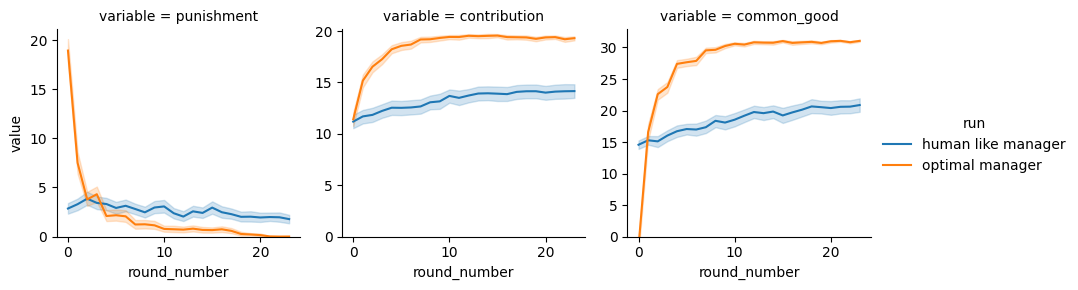

In [ ]:
w = dfm['run'].isin([
    'ah full managed by optimal',
    'ah full managed by humanlike',
    # 'pilot human manager',
    # 'pilot rule based manager',
])

dfg = dfm[w].copy()
dfg['run'] = dfg['run'].map({
    'ah full managed by optimal': 'optimal manager',
    'ah full managed by humanlike': 'human like manager',
})


g = sns.relplot(
    data=dfg,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)


# Set y-axis limits to start at 0 for all plots
g.set(ylim=(0, None))

g.savefig(os.path.join(plot_folder, 'comparison_manager.jpg'))

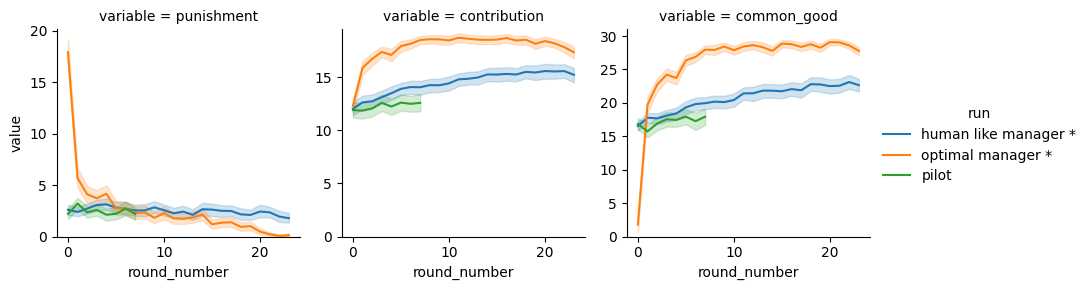

In [ ]:
w = dfm['run'].isin([
    'ah human managed managed by optimal',
    'ah human managed managed by humanlike',
    'pilot human manager',
    # 'pilot rule based manager',
])

dfg = dfm[w].copy()
dfg['run'] = dfg['run'].map({
    'ah human managed managed by optimal': 'optimal manager *',
    'ah human managed managed by humanlike': 'human like manager *',
    'pilot human manager': 'pilot',
    'pilot rule based manager': 'pilot rule based manager'
})


g = sns.relplot(
    data=dfg,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

# Set y-axis limits to start at 0 for all plots
g.set(ylim=(0, None))

g.savefig(os.path.join(plot_folder, 'comparison_pilot.jpg'))

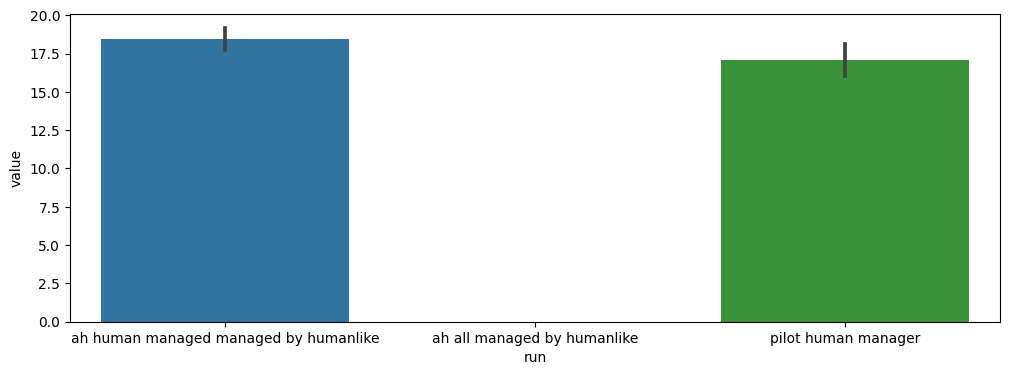

In [ ]:
try:
    from statannotations.Annotator import Annotator
    import matplotlib.pyplot as plt

    order = ['ah human managed managed by humanlike', 'ah all managed by humanlike', 'pilot human manager']

    w = (
        (dfm['round_number'] < 8) &
        (dfm['variable'] == 'common_good') &
        (dfm['run'].isin(order))
    )

    dfg = dfm[w].groupby(['participant_code', 'run', 'variable'])["value"].mean().reset_index()

    pairs = [[order[0], order[2]], [order[1], order[2]]]

    plt.figure(figsize=(12,4))

    ax = sns.barplot(
        data=dfg,
        order=order,
        x="run", 
        y="value")

    annotator = Annotator(ax, pairs, data=dfg, x='run', y='value', order=order)
    annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside')
    annotator.apply_and_annotate()

    plt.savefig(os.path.join(plot_folder, 'comparison_pilot_bar.jpg'))
except:
    pass

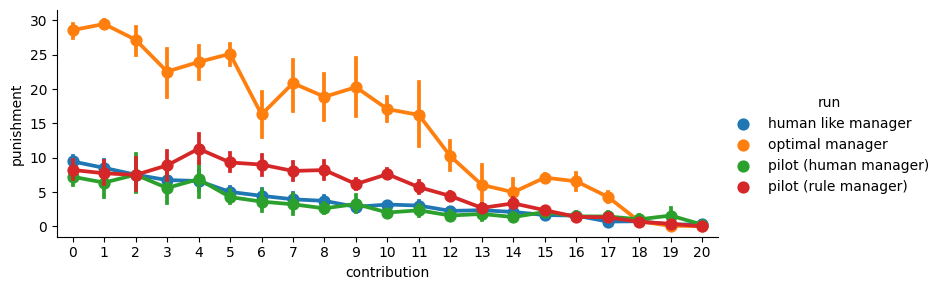

In [ ]:
df['contribution'] = df['contribution'].astype(int)


w = df['run'].isin([
    'ah full managed by optimal',
    'ah full managed by humanlike',
    'pilot human manager',
    'pilot rule based manager',
])

dfss = df[w].copy()
dfss['run'] = dfss['run'].map({
    'ah full managed by optimal': 'optimal manager',
    'ah full managed by humanlike': 'human like manager',
    'pilot human manager': 'pilot (human manager)',
    'pilot rule based manager': 'pilot (rule manager)'
})


g = sns.catplot(
    data=dfss,
    x="contribution", 
    y="punishment",
    hue='run',
    kind="point",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy.jpg'))

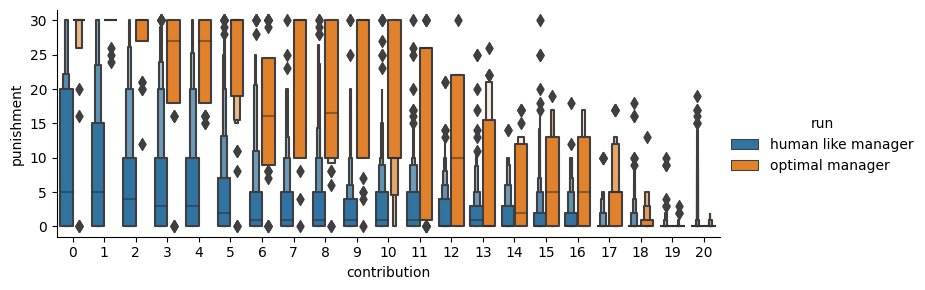

In [ ]:
df['contribution'] = df['contribution'].astype(int)

w = df['run'].isin([
    'ah full managed by optimal',
    'ah full managed by humanlike',
    # 'pilot human manager',
    # 'pilot rule based manager',
])

dfss = df[w].copy()
dfss['run'] = dfss['run'].map({
    'ah full managed by optimal': 'optimal manager',
    'ah full managed by humanlike': 'human like manager',
    'pilot human manager': 'pilot (human manager)',
    'pilot rule based manager': 'pilot (rule manager)'
})


g = sns.catplot(
    data=dfss,
    x="contribution", 
    y="punishment",
    hue='run',
    kind="boxen",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy_box.jpg'))

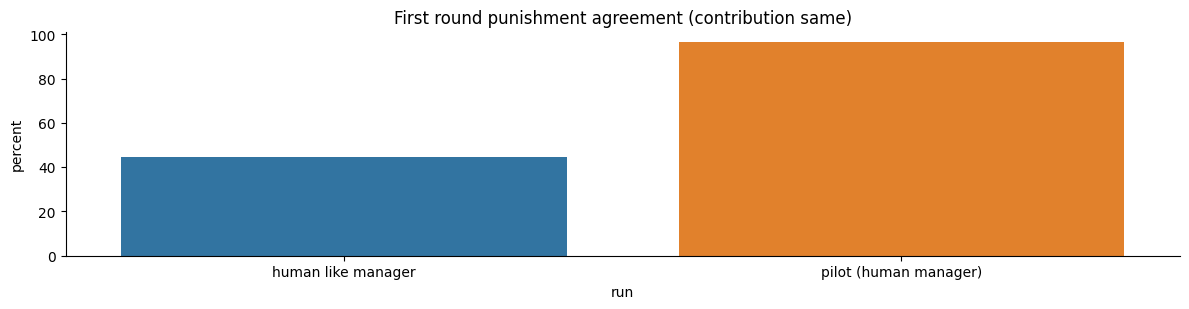

In [ ]:
df['contribution'] = df['contribution'].astype(int)

w = (df['run'].isin([
    'ah human managed managed by humanlike',
    'pilot human manager',
]) & (df['round_number'] == 0) & (df['contribution'] != 20))

dfss = df[w].copy()


dfss['run'] = dfss['run'].map({
    'ah human managed managed by humanlike': 'human like manager',
    'pilot human manager': 'pilot (human manager)',
})

merge_on = ['run','episode', 'round_number']
keep = ['punishment', 'contribution', 'participant_code']

dfm = pd.merge(left=dfss[merge_on+keep], right=dfss[merge_on+keep], on=merge_on)
dfm = dfm[dfm['participant_code_x'] != dfm['participant_code_y']]
dfm['contribution_same'] = dfm['contribution_x'] == dfm['contribution_y']
dfm['punishment_same'] = dfm['punishment_x'] == dfm['punishment_y']
dfm['punishment_diff'] = np.abs(dfm['punishment_x'] - dfm['punishment_y'])


x,y = 'run', 'punishment_same', 

w = dfm['contribution_same']

y_name = 'percent'

((dfm[w]
.groupby(x)[y]
.mean()
.mul(100)
.rename(y_name))
.reset_index()
.pipe((sns.catplot,'data'), x=x, y=y_name,kind='bar', height=3, aspect=4))

# set title
plt.title('First round punishment agreement (contribution same)')
plt.savefig(os.path.join(plot_folder, 'first_round_punishment_agreement.jpg'))
plt.show()

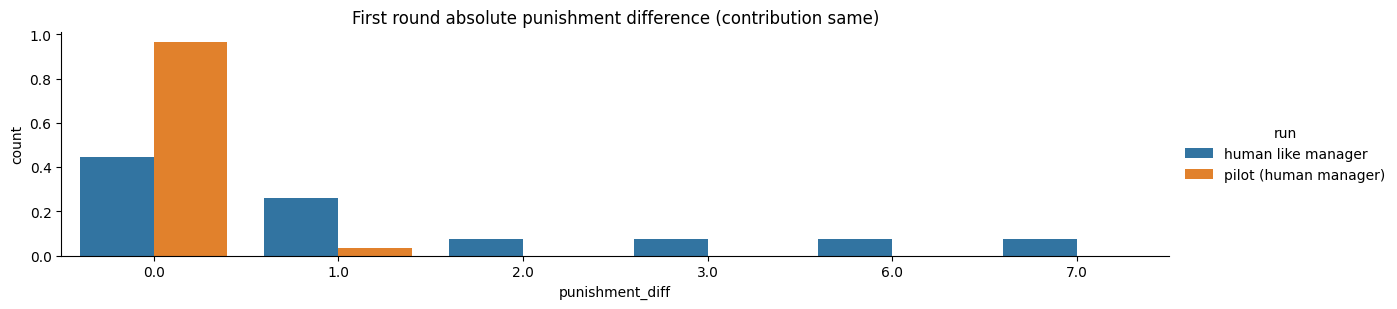

In [ ]:
x,y = 'run', 'punishment_diff', 

w = dfm['contribution_same']

y_name = 'count'

((dfm[w]
.groupby(x)[y]
.value_counts(normalize=True)
.rename(y_name))
.reset_index()
.pipe((sns.catplot,'data'), x=y, y=y_name, hue=x,kind='bar', height=3, aspect=4))

plt.title('First round absolute punishment difference (contribution same)')
plt.savefig(os.path.join(plot_folder, 'first_round_punishment_difference.jpg'))
plt.show()


In [ ]:
dfm = df.melt(
    id_vars=['episode', 'round_number', 'participant_code', 'run'], 
    value_vars=['punishment', 'contribution', 'common_good'])

# w = ((dfm['round_number'] == 0) & (dfm['variable'] == 'contribution'))

dfss = dfm.groupby(['run', 'round_number', 'variable'])['value'].mean().reset_index()

dfss = dfss.sort_values(['variable','round_number', 'run'])

dfss.to_csv(os.path.join(plot_folder, 'aggregates.csv'), index=False)

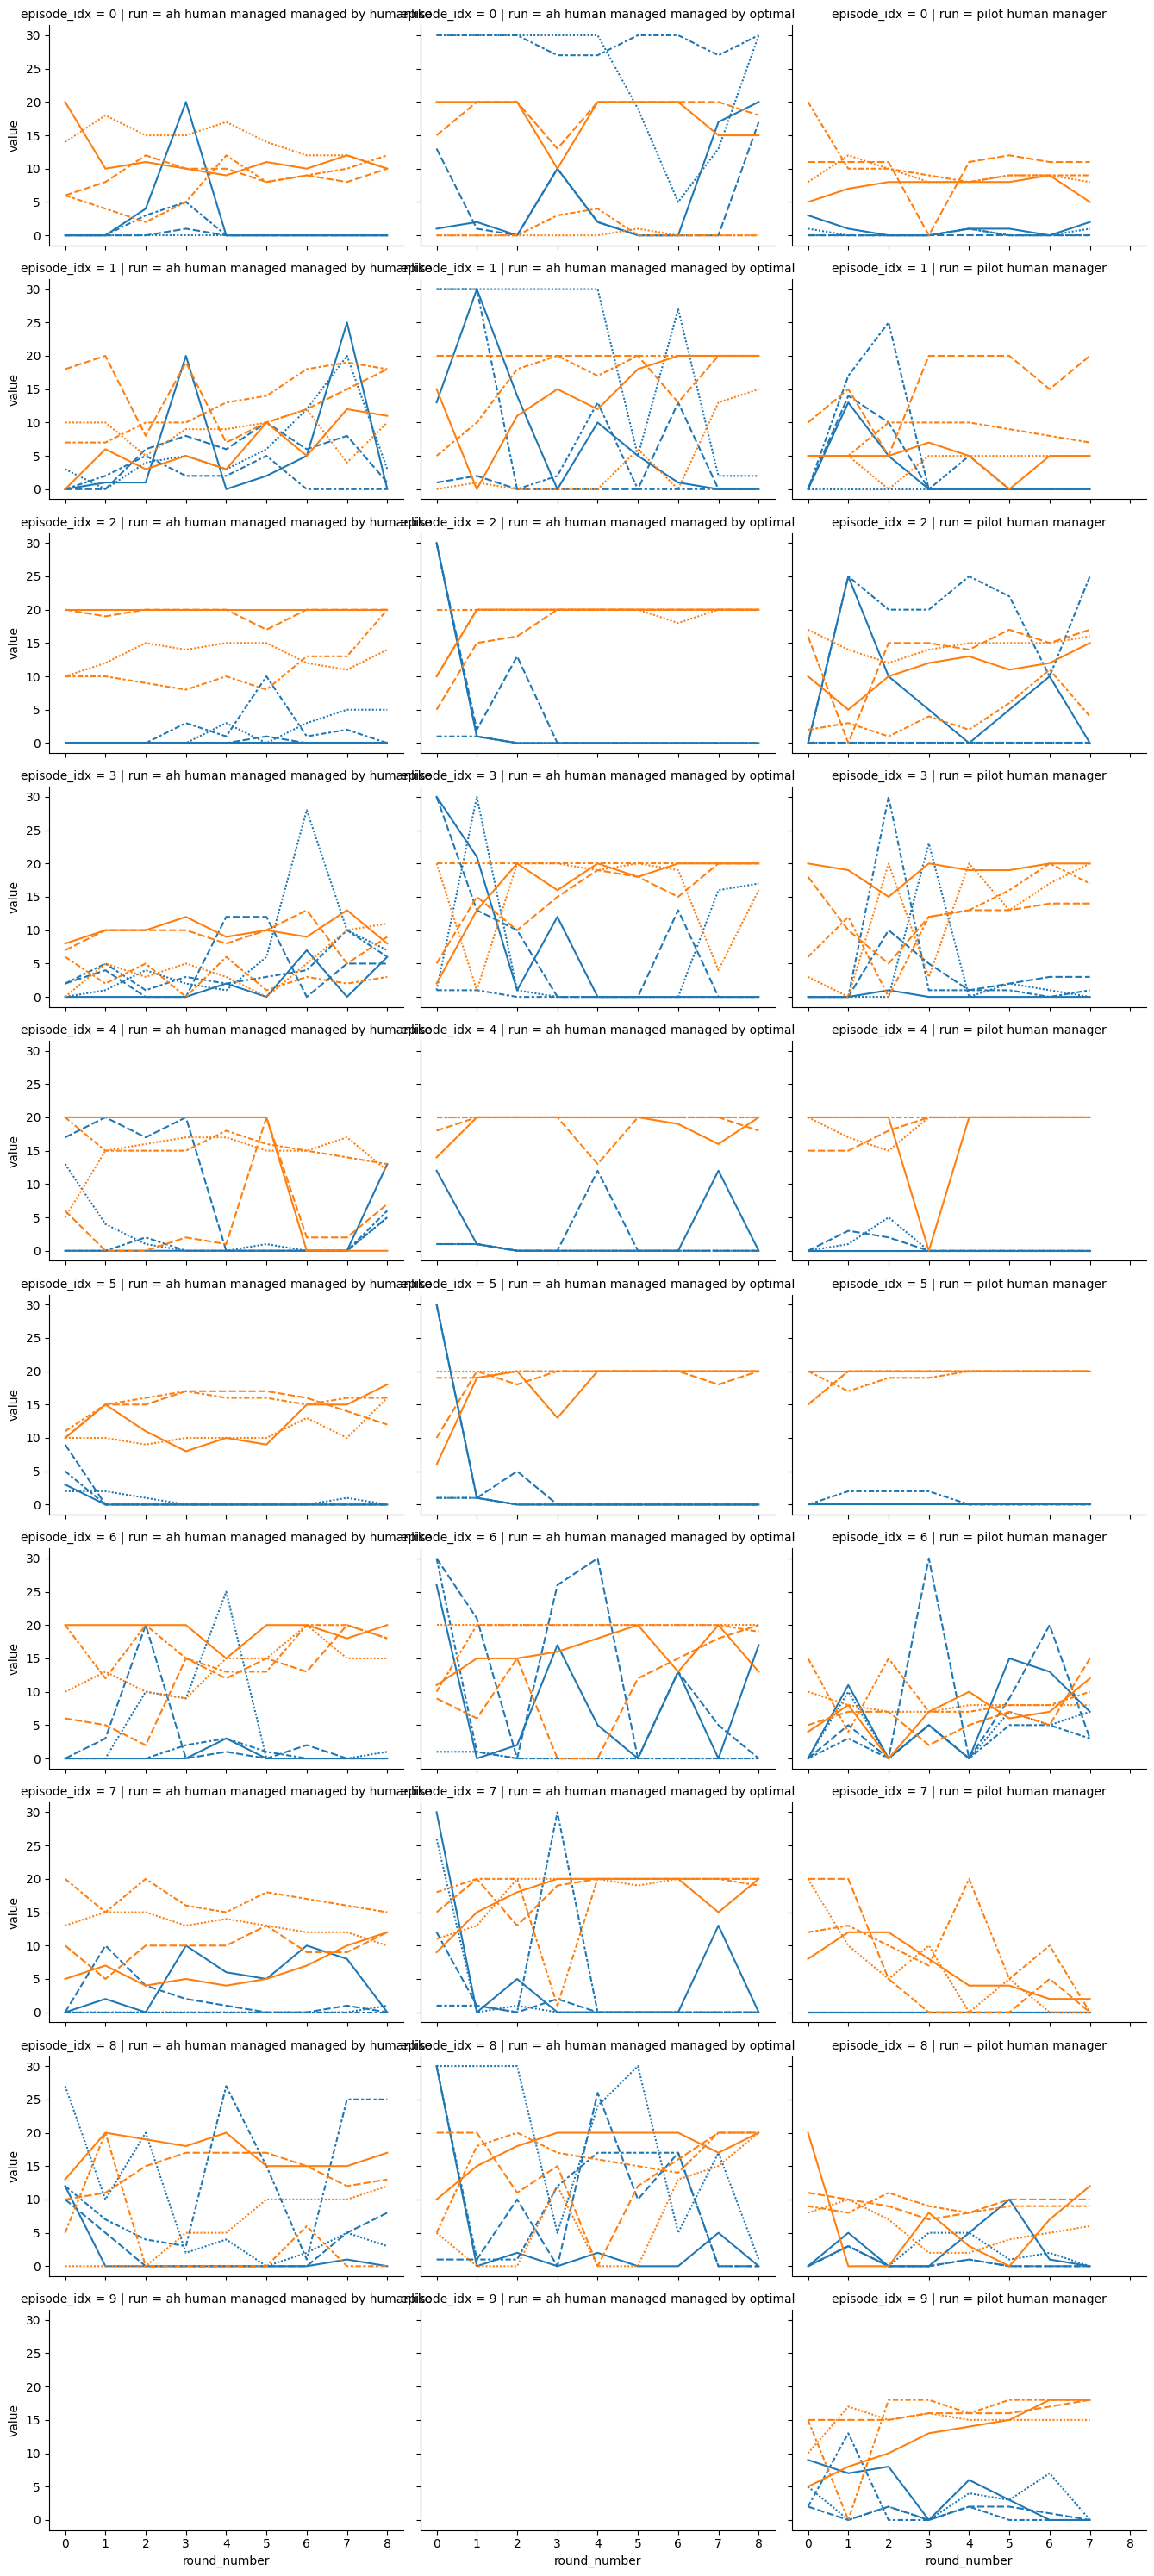

In [ ]:
w = dfm['run'].isin([
    'ah human managed managed by optimal',
    'ah human managed managed by humanlike',
    'pilot human manager',
    # 'pilot rule based manager',
]) & (dfm['round_number'] <= 8) & (dfm['variable'].isin(['contribution', 'punishment']))

# 10 random episodes from each run 
episodes = dfm[w].groupby('run')['episode'].unique().apply(lambda x: np.random.choice(x, 10)).explode().values

df_selected = dfm[w & dfm['episode'].isin(episodes)].copy()

# enumerate episodes grouped by run
df_selected['episode_idx'] = df_selected.groupby('run')['episode'].transform(lambda x: x.factorize()[0])

# create group idx for each group 

# lineplot col by run, row by group, hue by variable, x by round, y by value,
# no aggregation, but one line for each participant
g = sns.FacetGrid(df_selected, col='run', row='episode_idx', hue='variable',
                  sharex=True, sharey=True, height=3, aspect=1.5)
g.map(lambda x, y, p, **kwargs: sns.lineplot(x=x, y=y, style=p, estimator=None, **kwargs), 'round_number', 'value', 'participant_code')
